<a href="https://colab.research.google.com/github/sangitainst/HMD/blob/main/Text_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print("success")

success


# Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load train and validation data from Facebook HMD dataset

In [3]:
folder_path_train ="/content/drive/MyDrive/HMD_project/train.jsonl"
folder_path_dev ="/content/drive/MyDrive/HMD_project/dev.jsonl"
df_train = pd.read_json(folder_path_train,lines=True)
df_dev=pd.read_json(folder_path_dev,lines=True)

print(df_dev.tail())

        id            img  label  \
495  83675  img/83675.png      0   
496  37198  img/37198.png      0   
497  48670  img/48670.png      0   
498   9863  img/09863.png      0   
499  97320  img/97320.png      0   

                                                  text  
495                   i'm gonna be like phelps one day  
496  when you're so relaxed you can feel yourself g...  
497  look at this sandwich maker club i found on wi...  
498                             diverse group of women  
499  "when your dishwasher is broken so you take it...  


# check distribution of data in train and validation dataset

Distribution of training dataset
 0    5450
1    3050
Name: label, dtype: int64 

Distribution of validation dataset
 1    250
0    250
Name: label, dtype: int64


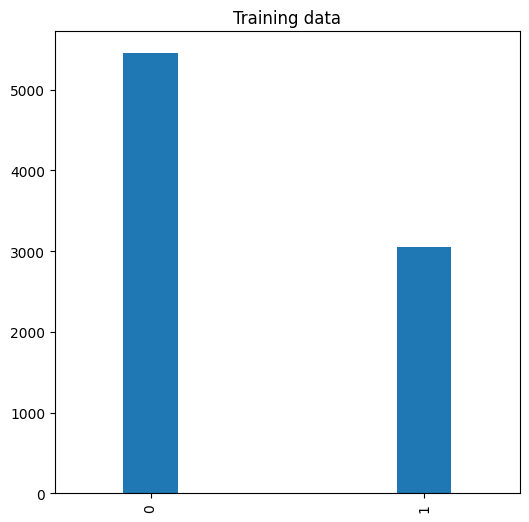

In [4]:
# distribution of movies based on certificate
df_train['label'].value_counts().plot(kind='bar', figsize=(6, 6),width=0.2,title='Training data')

print('Distribution of training dataset\n',df_train.label.value_counts(),"\n")
print("Distribution of validation dataset\n",df_dev.label.value_counts())

# Check null values

In [5]:
print(df_train.isna().sum())

print("\n\n",df_dev.isna().sum())

id       0
img      0
label    0
text     0
dtype: int64


 id       0
img      0
label    0
text     0
dtype: int64


# form the text file load the text corresponding to the augmented images

In [6]:
with open('/content/drive/MyDrive/HMD_project/new/text_aug_norm.txt','r') as f:
  lines=f.readlines()
  file_names=[]
  for i in lines:
    file_names.append(i[:i.find('\n')])
  print(type(file_names[0]))

<class 'str'>


# add augmented text in the training dataframe

In [7]:
for i in range(len(file_names)):
  df_train.loc[len(df_train.index)] = [1, 'img/1',1,file_names[i]] 


In [8]:
data = df_train

In [9]:
import spacy

# use sapcy 'en_core_web_sm" model fpr preporocessing

In [10]:
import spacy.cli
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# tokenize each word in a sentence and apply lemmatization on it, remove punctuation, space, brackets if any

In [11]:

def preprocess(text):
  doc=nlp(text)
  filtered_token=[]

  for token in doc:
  
    if token.is_punct or token.is_space or token.is_bracket or token.is_stop:
      continue
    else:
      token=token.lemma_
     
      filtered_token.append(token)
  return filtered_token
  
  


# example showing text preprocessing 

In [12]:
tokens=preprocess("My best friend Anu, (who is three months older than me) is coming to my house tonight!!!.")
tokens

['good', 'friend', 'Anu', 'month', 'old', 'come', 'house', 'tonight']

# Apply preprocessing on the text column of training dataset and validation dataset

In [13]:

df_dev['processed_text_val']=df_dev['text'].apply(lambda x: preprocess(x))

data['processed_text']=data['text'].apply(lambda x: preprocess(x))

data.head()


,id,img,label,text,processed_text
0,42953,img/42953.png,0,its their character not their color that matters,"[character, color, matter]"
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,"[afraid, love, like, ex]"
2,13894,img/13894.png,0,putting bows on your pet,"[put, bow, pet]"
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,"[love, everybody, squirrel, hate, squirrel]"
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...","[everybody, love, chocolate, chip, cookie, hit..."


# word2vec conversion using gensim 'glove-twitter-200' model

In [14]:

import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

import gensim.downloader as api
wv=api.load('glove-twitter-200')

# wv.save('/content/drive/MyDrive/HMD_project/glove-twitter-200')

# after saving the model load it from drive
# from gensim.models import KeyedVectors
# wv=KeyedVectors.load('/content/drive/MyDrive/HMD_project/glove-twitter-200')


['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']
[=================================================-] 99.6% 755.4/758.5MB downloaded


# function to get word vector and get average over a text

In [15]:
def gensim_vector(token):
  vec_size=wv.vector_size
  wv_final=np.zeros(vec_size) # take a vector consisting '0s' having size of wv

  count=1
  for t in token:
    if t in wv:
      count += 1
      wv_final += wv[t] # vectorize word and add to previous value

  return wv_final/count # take the average


# apply pretrained word2vec model on processed text column of the validation and training dataset

In [16]:

data["text_vector"]=data["processed_text"].apply(gensim_vector)
df_dev["text_vector_val"]=df_dev["processed_text_val"].apply(gensim_vector)


# word2vec embeddings of train and validation data

In [17]:
text_vector=data['text_vector']
text_vector=np.stack(text_vector)
print(text_vector.shape)
print(text_vector[0].shape)


text_vector_val=df_dev['text_vector_val']
text_vector_val=np.stack(text_vector_val)
print(text_vector_val.shape)
print(text_vector_val[0].shape)



(10400, 200)
(200,)
(500, 200)
(200,)


# Use topic modeling for text embedding

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Topic modeling using BOW vectorizer and truncated SVD


In [19]:
vectorizer=CountVectorizer(stop_words="english")
svd=TruncatedSVD(n_components=1000)

# for training dataset
processed_text = data["processed_text"].apply(lambda x: " ".join(x))

text_vec = vectorizer.fit_transform(processed_text)
print("CountVectorizer shape_training dataset",text_vec.shape)

# for valiadation dataset
processed_text_val = df_dev["processed_text_val"].apply(lambda x: " ".join(x))

text_vec_val = vectorizer.transform(processed_text_val)
print("CountVectorizer shape_val dataset",text_vec_val.shape)


# training dataset
lsa_text = svd.fit_transform(text_vec)

print('\nvariance_captured_by 1000 components',svd.explained_variance_ratio_.sum())
# validation dataset
lsa_text_val = svd.transform(text_vec_val)


print('\n',lsa_text.shape)
print(lsa_text_val.shape)

CountVectorizer shape_training dataset (10400, 6879)
CountVectorizer shape_val dataset (500, 6879)

variance_captured_by 1000 components 0.8180880994378601

 (10400, 1000)
(500, 1000)



# topic encoded text vector using NMF on TFIDF vectorizer

In [20]:
from sklearn.decomposition import NMF
vectorizer=TfidfVectorizer()
nmf = NMF(n_components=200)

# for training dataset
processed_text = data["processed_text"].apply(lambda x: " ".join(x))

text_vec_tfidf=vectorizer.fit_transform(processed_text)
print("CountVectorizer shape_training dataset",text_vec_tfidf.shape)

# for valiadation dataset
processed_text_val = df_dev["processed_text_val"].apply(lambda x: " ".join(x))

text_vec_tfidf_val = vectorizer.transform(processed_text_val)
print("CountVectorizer shape_val dataset",text_vec_tfidf_val.shape)


# training dataset
nmf_text = nmf.fit_transform(text_vec_tfidf)

# validation dataset
nmf_text_val=nmf.transform(text_vec_tfidf_val)


print(nmf_text.shape)
print(nmf_text_val.shape)

CountVectorizer shape_training dataset (10400, 6944)
CountVectorizer shape_val dataset (500, 6944)
(10400, 200)
(500, 200)
